# Imports

In [20]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import itertools
import datetime

# Variables and Utils

In [21]:
import sharedVariables
from sharedVariables import *  

def to_human_readable(size):
    power = 1000
    n = 0
    mem = {0 : 'B', 1: 'KB', 2: 'MB', 3: 'GB', 4: 'TB'}
    while size > power:
        size /=  power
        n += 1
    return "{0} {1}".format(size, mem[n])

# Data Preparation

In [32]:
def filterDataForLocalTraffic(df): 
    df = df[df["jsonPayload.connection.src_ip"].str.contains(r'^10\.')]
    df = df[df["jsonPayload.connection.dest_ip"].str.contains(r'^10\.')]
    return df

df_sync = loadData('data/20210721/experiment-syncmesh-with-latency.log')
df_base = loadData('data/20210721/experiment-baseline-with-latency.log')

orig_df = df_sync

df_sync = filterDataForLocalTraffic(df_sync)
df_base = filterDataForLocalTraffic(df_base)


# TODO: Filter Entries for port specific traffic



nodes = list(dict.fromkeys(df_base["jsonPayload.connection.dest_ip"].unique().tolist() + df_base["jsonPayload.connection.src_ip"].unique().tolist()))
nodes = [node for node in nodes if node not in [ip_client, ip_server, ip_orchestrator]]
# print(nodes)

# Print Table
# df[["jsonPayload.connection.src_ip", "jsonPayload.connection.src_port", "jsonPayload.connection.dest_ip", "jsonPayload.bytes_sent", "jsonPayload.rtt_msec"]].unique()
df_sync.index



DatetimeIndex(['2021-07-20 23:39:04.883558+00:00',
               '2021-07-20 23:39:04.883558+00:00',
               '2021-07-20 23:39:17.408977+00:00',
               '2021-07-20 23:39:17.408977+00:00',
               '2021-07-20 23:39:17.408977+00:00',
               '2021-07-20 23:39:17.408977+00:00',
               '2021-07-20 23:39:19.103964+00:00',
               '2021-07-20 23:39:19.103964+00:00',
               '2021-07-20 23:39:19.103964+00:00',
               '2021-07-20 23:39:19.103964+00:00',
               '2021-07-20 23:39:19.103964+00:00',
               '2021-07-20 23:39:19.103964+00:00',
               '2021-07-20 23:39:19.907288+00:00',
               '2021-07-20 23:39:19.907288+00:00',
               '2021-07-20 23:39:19.887085+00:00',
               '2021-07-20 23:39:19.887085+00:00',
               '2021-07-20 23:39:19.887085+00:00',
               '2021-07-20 23:39:19.887085+00:00',
               '2021-07-20 23:39:19.887085+00:00',
               '2021-07-20 23:3

In [33]:
def calcSubset(df):

    fromClient = df[df['jsonPayload.connection.src_ip']==ip_client]
    toServer = df[df['jsonPayload.connection.dest_ip']==ip_server]


    fromClientDataset = {}
    toServerDataset = {}
    betweenNodesDataset = {}
    for node in nodes: 
        fromClientDataset[node] = fromClient[fromClient['jsonPayload.connection.dest_ip']==node]

    nodeCombinations = list(itertools.combinations(nodes, r=2))
    for combination in nodeCombinations: 
        # Use both src_ip and dest_ip as they are not request related
        fromNode = df[df['jsonPayload.connection.src_ip'].isin(combination)]
        # fromAnyNode = df[df["jsonPayload.connection.src_ip"].isin(nodes)]
        betweenNodesDataset["between " + combination[0] + " and " + combination[1]] = fromNode[fromNode['jsonPayload.connection.dest_ip'].isin(combination)]

    for node in nodes: 
        toServerDataset[node] = toServer[toServer['jsonPayload.connection.src_ip']==node]
    
    return fromClientDataset, toServerDataset, betweenNodesDataset

fromClientDataset, toServerDataset, betweenNodesDataset = calcSubset(df_base)

# print(nodeCombinations)
# toServer.head()
# toServerDataset["10.2.0.12"].head()
# betweenNodesDataset['between 10.1.0.11 and 10.3.0.13'].info()
# fromClientDataset

# Results

## General

Text(0.5, 0, 'Round Trip Time (msec)')

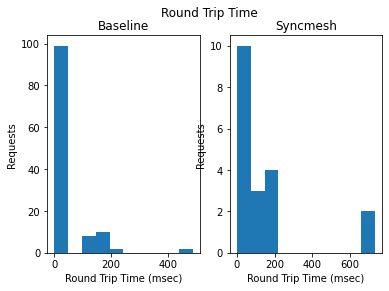

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Round Trip Time')
base_remove0 = df_base[df_base['jsonPayload.bytes_sent']!=0]
sync_remove0 = df_sync[df_sync['jsonPayload.bytes_sent']!=0]
ax1.hist(base_remove0['jsonPayload.rtt_msec'])
ax1.set_title("Baseline")
ax1.set_ylabel("Requests")
ax1.set_xlabel("Round Trip Time (msec)")
ax2.hist(sync_remove0['jsonPayload.rtt_msec'])
ax2.set_title("Syncmesh")
ax2.set_ylabel("Requests")
ax2.set_xlabel("Round Trip Time (msec)")

## Case: Baseline (Central Mongo)

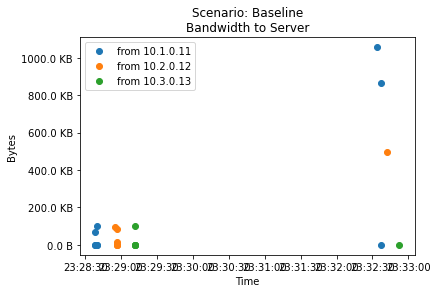

In [35]:
fig, ax = plt.subplots()
# ax.set_ylim(0,500)
for key in toServerDataset: 
    ax.plot(toServerDataset[key].index, toServerDataset[key]["jsonPayload.bytes_sent"], label="from " + key, marker='o', linestyle='None')
# set title and legend
ax.set_title('Scenario: Baseline\nBandwidth to Server')
ax.set_ylabel("Bytes")
ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in  
                    ax.get_yticks(minor=False)])
ax.set_xlabel("Time")
ax.legend()
fig.savefig("out/bandwidth_to_server.png")
plt.show()

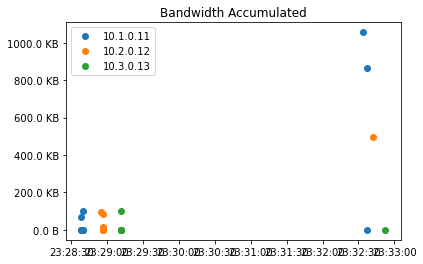

In [36]:
fig, ax = plt.subplots()
# ax.set_ylim(0,500)
for key in toServerDataset: 
    ax.plot(toServerDataset[key].index, toServerDataset[key]["jsonPayload.bytes_sent"], label=key, marker='o', linestyle='None')
# set title and legend
ax.set_title('Bandwidth Accumulated')
ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in  
                    ax.get_yticks(minor=False)])
ax.legend()
plt.show()

## Case: Syncmesh

In [37]:
fromClientDataset, toServerDataset, betweenNodesDataset = calcSubset(df_sync)

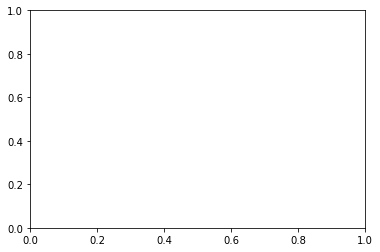

In [38]:
fig, ax = plt.subplots()
# plot histogram
binwidth = 10

# ax.hist(fromClientTo4['jsonPayload.bytes_sent'], bins=range(min(fromClientTo4['jsonPayload.bytes_sent']), max(fromClientTo4['jsonPayload.bytes_sent']) + binwidth, binwidth))
# ax.set_title("Package Size Histogram for Client to 4")

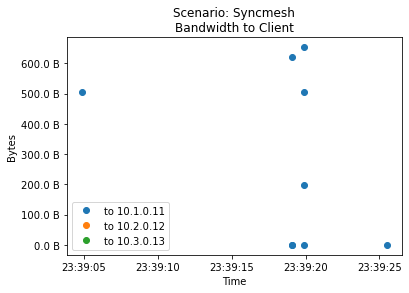

In [39]:
fig, ax = plt.subplots()
# ax.set_ylim(0,500)
for key in fromClientDataset: 
    ax.plot(fromClientDataset[key].index, fromClientDataset[key]["jsonPayload.bytes_sent"], label="to " + key, marker='o', linestyle='None')
# set title and legend
ax.set_title('Scenario: Syncmesh\nBandwidth to Client')
ax.set_ylabel("Bytes")
ax.set_xlabel("Time")
ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in  
                    ax.get_yticks(minor=False)])
ax.legend()
# fig.savefig("out/bandwidth_from_client.png")
plt.show()

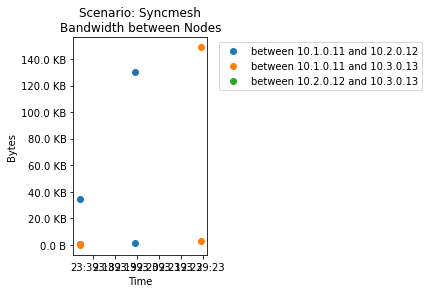

In [40]:
fig, ax = plt.subplots()

# ax.set_ylim(0,500)
for key in betweenNodesDataset: 
    ax.plot(betweenNodesDataset[key].index, betweenNodesDataset[key]["jsonPayload.bytes_sent"], label=key, marker='o', linestyle='None')
# set title and legend
ax.set_title('Scenario: Syncmesh\nBandwidth between Nodes')
ax.set_ylabel("Bytes")
ax.set_xlabel("Time")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.4, box.height])
ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in  
                    ax.get_yticks(minor=False)])
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

fig.savefig("out/bandwidth_between_nodes.png")
plt.show()

# Comparison

In [41]:
timedfbaseline = df.loc['2021-7-7 16:10':'2021-7-7 16:14']

baselineAggregateBytes = timedfbaseline["jsonPayload.bytes_sent"].sum()
baselineAggregateRTT = timedfbaseline["jsonPayload.rtt_msec"].sum()

timedfaggregate = df.loc['2021-7-7 16:06':'2021-7-7 16:08']

syncmeshAggregateBytes = timedfaggregate["jsonPayload.bytes_sent"].sum()
syncmeshAggregateRTT = timedfaggregate["jsonPayload.rtt_msec"].sum()

timedfcollect = df.loc['2021-7-7 16:03':'2021-7-7 16:05']

syncmeshCollectBytes = timedfcollect["jsonPayload.bytes_sent"].sum()
syncmeshCollectRTT = timedfcollect["jsonPayload.rtt_msec"].sum()

# timedfbaseline.info()

fig, ax = plt.subplots()
cases = ['Baseline', 'Syncmesh\nAggregate', 'Syncmesh\nCollect']
values = [baselineAggregateBytes, syncmeshAggregateBytes, syncmeshCollectBytes]
print(values)
ax.bar(cases,values)
ax.set_title('Comparison: Bytes')
ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in  
                    ax.get_yticks(minor=False)])
# ax.set_ylabel("Bytes")
# ax.set_xlabel("Time")
fig.savefig("out/comparison.png")
plt.show()

NameError: name 'df' is not defined

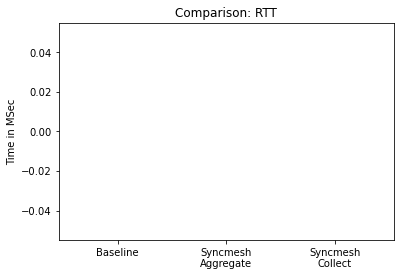

In [ ]:
fig, ax = plt.subplots()
cases = ['Baseline', 'Syncmesh\nAggregate', 'Syncmesh\nCollect']
values = [baselineAggregateRTT, syncmeshAggregateRTT, syncmeshCollectRTT]
ax.bar(cases,values)
ax.set_title('Comparison: RTT')
ax.set_ylabel("Time in MSec")
# ax.set_xlabel("Time")
fig.savefig("out/comparison_rtt.png")
plt.show()